In [257]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from pandas import read_csv
from pandas import datetime
from matplotlib import pyplot

from tqdm import tqdm #A tqdm progress bar shows you how much time has elapsed and the estimated time remaining for the iterable

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
#  Holt-Winters ETS
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from fbprophet import Prophet
import statsmodels.api as sm
import pmdarima as pm
import sklearn.metrics as skmetrics

from statsmodels.tsa.stattools import adfuller

from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

/var/folders/z9/4f614mq96694683lr3575mjh0000gn/T/ipykernel_16308/3179699621.py:6: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


In [258]:
df_zillow = pd.read_csv('zillow-carlifornia.csv', parse_dates=['Date'])
df_zillow.rename(columns={'MedianSoldPrice_AllHomes.California':'sold_price'},inplace=True)

In [259]:
df_test = pd.read_csv('test.csv', parse_dates=['Month'])
df_test.rename(columns={'Month':'Date'},inplace=True)

In [260]:
train = df_zillow[df_zillow.Date<'2016-01-31'].copy()
test = df_zillow[df_zillow.Date>='2016-01-31'].copy()
test['sold_price'] = df_test['Median House Price'].values

In [261]:
train.head()

,Date,sold_price,MedianMortageRate,UnemploymentRate
0,2008-02-29,470000.0,5.29,6.3
1,2008-03-31,441000.0,5.44,6.2
2,2008-04-30,460000.0,5.42,6.4
3,2008-05-31,429000.0,5.47,6.3
4,2008-06-30,437500.0,5.60,6.2


In [262]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0,1))

train_sc = sc.fit_transform(train.iloc[:,1:].values )
test_sc = sc.transform(test.iloc[:,1:].values )

df_train_sc = pd.DataFrame(train_sc,columns=['sold_price','MedianMortageRate','UnemploymentRate'])


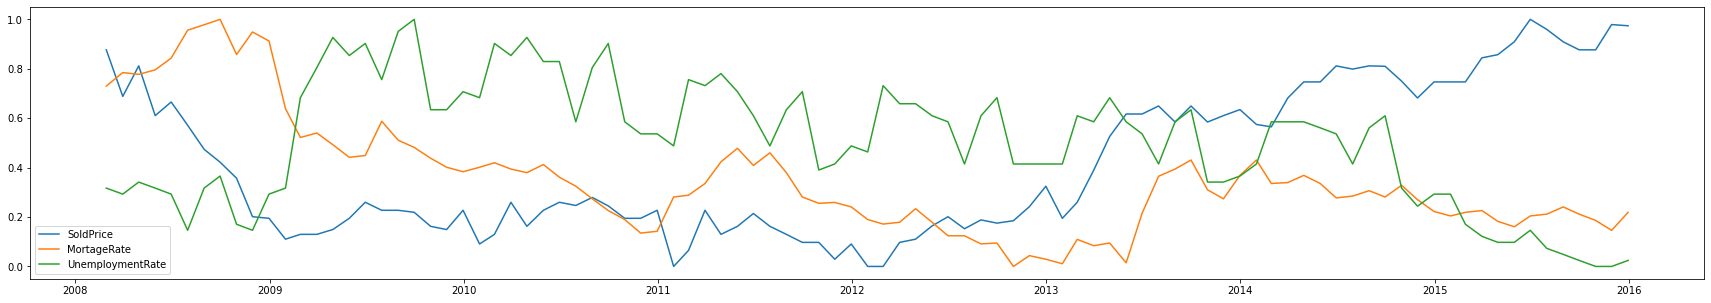

In [263]:
fig = plt.figure(figsize=(30, 5))
ax = fig.add_subplot(111)
#fig = plt.figure(figsize=(30, 5))

ax.plot(df_train_sc.set_index(train['Date']).sold_price, label = 'SoldPrice')
ax.plot(df_train_sc.set_index(train['Date']).MedianMortageRate, label = 'MortageRate')
ax.plot(df_train_sc.set_index(train['Date']).UnemploymentRate, label = 'UnemploymentRate')
ax.legend()
plt.show()

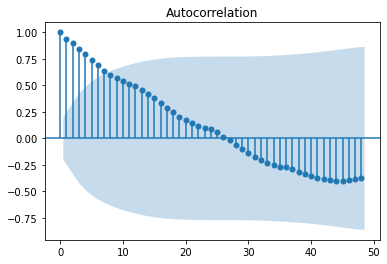

In [264]:
plot_acf(train.sold_price,lags=48) 
plt.show()


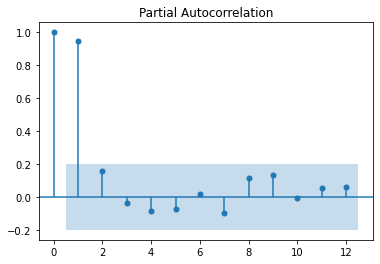

In [265]:
plot_pacf(train.sold_price,lags=12) 
plt.show()

In [266]:
#ADF Fuller test
dftest = adfuller(train.sold_price)
dfoutput = pd.Series(dftest[0:2], index=['Test Statistic','p-value'])
print (dfoutput)

Test Statistic   -0.058792
p-value           0.953391
dtype: float64


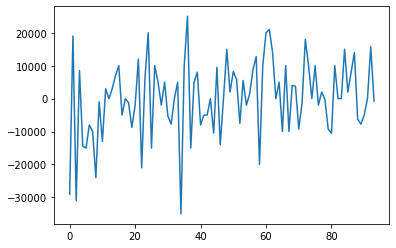

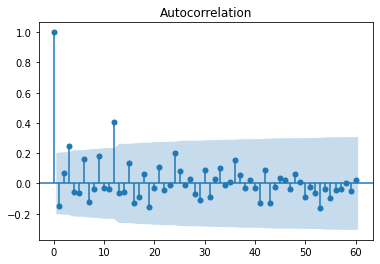

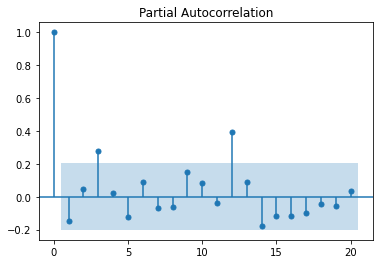

In [267]:
#Differencing
def diff(data, interval=1):
    diff = list()
    for i in range(interval, len(data)):
        value = data[i] - data[i - interval]
        diff.append(value)
    return diff

# fit a trend only model 
# determine d
d1 = diff(train.sold_price, 1)
plt.plot(d1)
plot_acf(d1,lags=60) 
plt.show()
plot_pacf(d1,lags=20) 
plt.show()

In [268]:
diff_1 = diff(train.sold_price,interval=1)
dftest = adfuller(diff_1)
dfoutput = pd.Series(dftest[0:2], index=['Test Statistic', 'p-value'])
print(dfoutput)

Test Statistic   -3.088139
p-value           0.027443
dtype: float64


In [269]:
def bic_sarimax(data,ex, p_values,d_values,q_values,P_values,Q_values,m, D):
    
    sc1 = MinMaxScaler(feature_range = (0,1))
    sc2 = MinMaxScaler(feature_range = (0,1))
    sc1.fit(data.values.reshape(-1, 1))
    data=sc1.transform(data.values.reshape(-1, 1))
    sc2.fit(ex.values.reshape(-1, 1))
    data=sc2.transform(ex.values.reshape(-1, 1))
    
    best_score, best_order, best_seasonal_order = float("inf"), None, None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                for P in P_values:
                    for Q in Q_values:
                        order=(p,d,q)
                        #print(order)
                        #print(seasonal_order)
                        seasonal_order=(P,D,Q,m)
#                         try:
                        res = sm.tsa.statespace.SARIMAX(data,exog=ex,order=order,seasonal_order=seasonal_order,enforce_stationarity=False,enforce_invertibility=False).fit()
                        bic=res.bic
                        #print(bic)
                        if bic < best_score:
                            best_score, best_order, best_seasonal_order=bic, order,seasonal_order
#                         except:
#                             continue
    print((best_score, best_order, best_seasonal_order))

In [270]:
#bic_sarimax(train.iloc[:,1],train.iloc[:,3:4], p_values=range(5),d_values=range(2),q_values=range(3),
           #P_values=range(3),Q_values=range(3),m=12, D=1)

### SARIMAX model:

In [271]:
def evaluate_sarimax_model(data1, data2, trend_order, seasonal_order, split):
    train_size = int(len(data1) * split)
    sc1 = MinMaxScaler(feature_range = (0,1))
    sc2 = MinMaxScaler(feature_range = (0,1))
    
    train_data1, test_data1 = data1[0:train_size], data1.iloc[train_size:]
    train_data2, test_data2 = data2[0:train_size], data2.iloc[train_size:]
    
    
    predictions = list()
    for t in tqdm(range(len(test_data1))):
        
        sc1.fit(train_data1.iloc[:train_size+t].values.reshape(-1, 1))
        sc2.fit(train_data2.iloc[:train_size+t].values)

        data1_sc = sc1.transform(data1[:train_size+t].values.reshape(-1, 1))
        data2_sc = sc2.transform(data2[:train_size+t+1].values)
            
        model = sm.tsa.statespace.SARIMAX(data1_sc,exog=data2_sc[:train_size+t], order=trend_order,seasonal_order=seasonal_order) #rolling forward for one step at each time
        model_fit = model.fit()
        y_hat = np.asanyarray(model_fit.forecast(exog=data2_sc[train_size+t,:]))[0] #predict one step
        y_pred_inv = sc1.inverse_transform(y_hat.reshape(1, -1))[:,0]
        predictions.append(y_pred_inv) #store prediction
    predictions = np.asarray(predictions).reshape(-1,)
    test = np.asanyarray(test_data1).reshape(-1,)
    rmse = np.sqrt(skmetrics.mean_squared_error(test_data1, predictions))
    mape = mean_absolute_percentage_error(test_data1, predictions)
    return rmse, mape

### Model 1: Both exogenous variables

In [272]:
model1 = pm.auto_arima(train_sc[:,0], 
                      exogenous= train_sc[:,1:], 
                      start_p=2, start_q=0,
                      p=0, max_q=5, # maximum p and q
                      m=12,              # seasonal is set to False
                      d=None,           # let model determine 'd'
                      seasonal=True,   
                      start_P=0, start_Q=0,
                      max_P=3, max_Q=3,
                      D=1, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model1.summary())

Performing stepwise search to minimize aic
 ARIMA(2,2,0)(0,1,0)[12]             : AIC=-189.152, Time=0.16 sec
 ARIMA(0,2,0)(0,1,0)[12]             : AIC=-123.274, Time=0.04 sec
 ARIMA(1,2,0)(1,1,0)[12]             : AIC=-171.623, Time=0.39 sec
 ARIMA(0,2,1)(0,1,1)[12]             : AIC=-190.501, Time=0.46 sec
 ARIMA(0,2,1)(0,1,0)[12]             : AIC=-188.748, Time=0.14 sec
 ARIMA(0,2,1)(1,1,1)[12]             : AIC=inf, Time=0.58 sec
 ARIMA(0,2,1)(0,1,2)[12]             : AIC=inf, Time=1.84 sec
 ARIMA(0,2,1)(1,1,0)[12]             : AIC=-188.366, Time=0.28 sec
 ARIMA(0,2,1)(1,1,2)[12]             : AIC=-191.988, Time=2.06 sec
 ARIMA(0,2,1)(2,1,2)[12]             : AIC=inf, Time=2.27 sec
 ARIMA(0,2,1)(1,1,3)[12]             : AIC=inf, Time=3.99 sec
 ARIMA(0,2,1)(0,1,3)[12]             : AIC=-192.449, Time=2.95 sec
 ARIMA(0,2,0)(0,1,3)[12]             : AIC=inf, Time=2.98 sec
 ARIMA(1,2,1)(0,1,3)[12]             : AIC=-207.814, Time=3.33 sec
 ARIMA(1,2,1)(0,1,2)[12]             : AIC=i

In [ ]:
y_pred = model1.predict(n_periods=len(test_sc),X=test_sc[:,1:]).reshape(-1,1)
y_pred_ = np.repeat(y_pred,3,axis=1) # duplicate the pred column x3 times to fit the scaler's shape
y_pred_inv = sc.inverse_transform(y_pred_)[:,0]# inverset the pred and take the first column (gdp)

In [ ]:
mape_test_sarimax=(np.abs(np.array(test['sold_price'])-np.array(y_pred_inv))/np.array(test['sold_price'])).mean()
print(mape_test_sarimax)

In [ ]:
np.sqrt(skmetrics.mean_squared_error(test['sold_price'], np.array(y_pred_inv)))

In [112]:
trend_order = (2,1,0)
seasonal_order= (0,0,0,0)
rmse1, mape1 = evaluate_sarimax_model(train.iloc[:,1],train.iloc[:,3:4], trend_order, seasonal_order, split=0.67)

  0%|                                                    | 0/32 [00:00<?, ?it/s] This problem is unconstrained.
 This problem is unconstrained.
  6%|██▊                                         | 2/32 [00:00<00:01, 18.38it/s] This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -9.53282D-01    |proj g|=  8.96353D-01

At iterate    5    f= -9.55042D-01    |proj g|=  2.02615D-01

At iterate   10    f= -9.56626D-01    |proj g|=  5.13035D-02

At iterate   15    f= -9.56649D-01    |proj g|=  3.60955D-03

At iterate   20    f= -9.56650D-01    |proj g|=  4.52540D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     29      1     0     0   5.520D-04  -9.566D-01
  F = -0.95664988451808997     

CONVERG

 16%|██████▉                                     | 5/32 [00:00<00:01, 22.04it/s] This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 25%|███████████                                 | 8/32 [00:00<00:01, 23.78it/s]


At iterate   20    f= -9.64679D-01    |proj g|=  5.65507D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     25      1     0     0   4.277D-04  -9.647D-01
  F = -0.96467891002918449     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -9.66690D-01    |proj g|=  9.03882D-01

At iterate    5    f= -9.68370D-01    |proj g|=  1.75804D-01

At iterate   10    f= -9.69701D-01    |proj g|=  3.55913D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 34%|██████████████▊                            | 11/32 [00:00<00:00, 22.86it/s] This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 44%|██████████████████▊                        | 14/32 [00:00<00:00, 22.45it/s]

At iterate   10    f= -9.92470D-01    |proj g|=  9.01207D-02

At iterate   15    f= -9.92688D-01    |proj g|=  7.45024D-04

At iterate   20    f= -9.92688D-01    |proj g|=  1.48858D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     28      1     0     0   4.597D-05  -9.927D-01
  F = -0.99268845196154543     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -9.95106D-01    |proj g|=  9.28586D-01

At itera

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 53%|██████████████████████▊                    | 17/32 [00:00<00:00, 22.83it/s] This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -9.94467D-01    |proj g|=  8.93599D-01

At iterate    5    f= -9.96034D-01    |proj g|=  1.75775D-01

At iterate   10    f= -9.97192D-01    |proj g|=  5.91716D-02

At iterate   15    f= -9.97418D-01    |proj g|=  1.17453D-02

At iterate   20    f= -9.97418D-01    |proj g|=  7.86761D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     25      1     0     0   2.140D-05  -9.974D-01
  F = -0.99741824404564383     

CONVERG

 This problem is unconstrained.
 This problem is unconstrained.
 62%|██████████████████████████▉                | 20/32 [00:00<00:00, 21.07it/s] This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.01850D+00    |proj g|=  9.27752D-01

At iterate    5    f= -1.02009D+00    |proj g|=  1.73440D-01

At iterate   10    f= -1.02122D+00    |proj g|=  7.01283D-02

At iterate   15    f= -1.02148D+00    |proj g|=  1.21821D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     18     21      1     0     0   2.560D-04  -1.021D+00
  F =  -1.0214843804214493     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING 

 This problem is unconstrained.
 72%|██████████████████████████████▉            | 23/32 [00:01<00:00, 20.95it/s] This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 81%|██████████████████████████████████▉        | 26/32 [00:01<00:00, 21.32it/s] This problem is unconstrained.



At iterate   10    f= -1.03758D+00    |proj g|=  4.09032D-02

At iterate   15    f= -1.03776D+00    |proj g|=  8.11853D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     17     21      1     0     0   3.044D-04  -1.038D+00
  F =  -1.0377645469888186     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.02990D+00    |proj g|=  9.06022D-01

At iterate    5    f= -1.03138D+00    |proj g|=  1.60242D-01

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.
 91%|██████████████████████████████████████▉    | 29/32 [00:01<00:00, 21.06it/s] This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     44      1     0     0   4.662D-05  -1.038D+00
  F =  -1.0380390744954207     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.04036D+00    |proj g|=  9.09867D-01

At iterate    5    f= -1.04181D+00    |proj g|=  1.53988D-01

At iterate   10    f= -1.04285D+00    |proj g|=  3.55765D-02

At iterate   15    f= -1.04302D+00    |proj g|=  8.17115D-03

       


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.
100%|███████████████████████████████████████████| 32/32 [00:01<00:00, 20.83it/s]


At iterate   10    f= -1.05487D+00    |proj g|=  2.40022D-02

At iterate   15    f= -1.05493D+00    |proj g|=  1.18497D-03

At iterate   20    f= -1.05493D+00    |proj g|=  9.74768D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     26      1     0     0   1.310D-04  -1.055D+00
  F =  -1.0549283243297625     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.04696D+00    |proj g|=  8.99160D-01

At iter

In [113]:
rmse1

8838.259435494798

### Model 2: Only Median Mortgage Rate

In [114]:
model2 = pm.auto_arima(train_sc[:,0], 
                      exogenous= train_sc[:,1:2], 
                      start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=4, max_q=4, # maximum p and q
                      m=12,              # seasonal is set to False
                      d=1,           # let model determine 'd'
                      seasonal=True,   
                      start_P=0, start_Q=0,
                      max_P=3, max_Q=3,
                      max_D=1, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model2.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-215.475, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-239.081, Time=0.14 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-233.407, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-217.471, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-215.420, Time=0.06 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-237.142, Time=0.40 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-237.170, Time=0.30 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-233.959, Time=0.09 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=-235.225, Time=0.56 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=-238.215, Time=0.08 sec
 ARIMA(2,1,0)(1,0,0)[12] intercept   : AIC=-240.480, Time=0.18 sec
 ARIMA(2,1,0)(0,0,0)[12] intercept   : AIC=-213.886, Time=0.07 sec
 ARIMA(2,1,0)(2,0,0)[12] intercept   : AIC=-238.579, Time=0.59 sec
 ARIMA(2,1,0)(1,0,1)[12] intercept   : AIC=-238.623, Time=0.28 sec
 ARIMA(2,1,0)(0,0,1

In [115]:
trend_order = (1,1,2)
seasonal_order= (1,0,0,12)
rmse2, mape2 = evaluate_sarimax_model(train.iloc[:,1],train.iloc[:,2:3], trend_order, seasonal_order, split=0.8)

  5%|██▎                                         | 1/19 [00:00<00:02,  6.40it/s]

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.11769D+00    |proj g|=  1.84284D+00

At iterate    5    f= -1.13303D+00    |proj g|=  1.20392D+00

At iterate   10    f= -1.18757D+00    |proj g|=  1.06765D-01

At iterate   15    f= -1.20835D+00    |proj g|=  2.25830D-01

At iterate   20    f= -1.23086D+00    |proj g|=  1.74651D-01

At iterate   25    f= -1.23300D+00    |proj g|=  3.57126D-01

At iterate   30    f= -1.23361D+00    |proj g|=  2.08602D-02

At iterate   35    f= -1.23364D+00    |proj g|=  5.08560D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

 This problem is unconstrained.



At iterate   10    f= -1.19660D+00    |proj g|=  1.11066D-01


 11%|████▋                                       | 2/19 [00:00<00:02,  6.24it/s] This problem is unconstrained.



At iterate   15    f= -1.20379D+00    |proj g|=  1.42858D+00

At iterate   20    f= -1.22996D+00    |proj g|=  1.99003D-01

At iterate   25    f= -1.23794D+00    |proj g|=  3.71698D-02

At iterate   30    f= -1.24061D+00    |proj g|=  8.29636D-03

At iterate   35    f= -1.24061D+00    |proj g|=  2.05073D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     35     43      1     0     0   2.051D-03  -1.241D+00
  F =  -1.2406090701452250     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

 16%|██████▉                                     | 3/19 [00:00<00:02,  5.65it/s] This problem is unconstrained.



At iterate   30    f= -1.24612D+00    |proj g|=  9.33048D-02

At iterate   35    f= -1.24632D+00    |proj g|=  1.05765D-02

At iterate   40    f= -1.24632D+00    |proj g|=  1.38806D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     42     54      1     0     0   1.509D-04  -1.246D+00
  F =  -1.2463194311985011     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.13592D+00    |proj g|=  1.87768D+00

At iter

 26%|███████████▌                                | 5/19 [00:00<00:02,  5.92it/s]


At iterate   35    f= -1.24848D+00    |proj g|=  3.56713D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     37     45      1     0     0   5.825D-05  -1.248D+00
  F =  -1.2484808485017300     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.14108D+00    |proj g|=  1.82314D+00

At iterate    5    f= -1.15288D+00    |proj g|=  9.84853D-01

At iterate   10    f= -1.19979D+00    |proj g|=  7.89710D-01

At iter

 This problem is unconstrained.
 32%|█████████████▉                              | 6/19 [00:01<00:02,  5.63it/s]


At iterate    5    f= -1.15822D+00    |proj g|=  9.64914D-01

At iterate   10    f= -1.20293D+00    |proj g|=  7.78918D-01

At iterate   15    f= -1.22493D+00    |proj g|=  2.34277D-01

At iterate   20    f= -1.25188D+00    |proj g|=  9.79672D-02

At iterate   25    f= -1.25561D+00    |proj g|=  2.35415D-01

At iterate   30    f= -1.26009D+00    |proj g|=  6.54670D-02

At iterate   35    f= -1.26067D+00    |proj g|=  1.14392D-02

At iterate   40    f= -1.26068D+00    |proj g|=  6.81088D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     43     52      1     0     0   1.306D-04  -1.261D+00
  F =  -1.26068301615

 This problem is unconstrained.



At iterate    5    f= -1.15131D+00    |proj g|=  9.62423D-01


 37%|████████████████▏                           | 7/19 [00:01<00:02,  5.90it/s] This problem is unconstrained.



At iterate   10    f= -1.19454D+00    |proj g|=  7.07985D-01

At iterate   15    f= -1.21686D+00    |proj g|=  2.05138D-01

At iterate   20    f= -1.24188D+00    |proj g|=  8.68095D-01

At iterate   25    f= -1.25134D+00    |proj g|=  7.53253D-02

At iterate   30    f= -1.25165D+00    |proj g|=  2.76311D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     32     39      1     0     0   2.410D-05  -1.252D+00
  F =  -1.2516510885317869     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 42%|██████████████████▌                         | 8/19 [00:01<00:02,  5.03it/s]


At iterate   25    f= -1.25377D+00    |proj g|=  4.45723D-02

At iterate   30    f= -1.25800D+00    |proj g|=  4.49365D-02

At iterate   35    f= -1.25823D+00    |proj g|=  4.78977D-04

At iterate   40    f= -1.25823D+00    |proj g|=  1.51106D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     40     72      2     0     0   1.511D-04  -1.258D+00
  F =  -1.2582314347347356     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.
 47%|████████████████████▊                       | 9/19 [00:01<00:01,  5.07it/s] This problem is unconstrained.


At iterate   10    f= -1.19957D+00    |proj g|=  5.96078D-01

At iterate   15    f= -1.21851D+00    |proj g|=  1.35581D-01

At iterate   20    f= -1.23482D+00    |proj g|=  8.49472D-01

At iterate   25    f= -1.24798D+00    |proj g|=  2.74960D-01

At iterate   30    f= -1.25631D+00    |proj g|=  3.48522D-02

At iterate   35    f= -1.25661D+00    |proj g|=  4.08630D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     36     50      1     0     0   4.086D-04  -1.257D+00
  F =  -1.2566111428692759     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine

 53%|██████████████████████▋                    | 10/19 [00:01<00:01,  5.07it/s] This problem is unconstrained.



At iterate   15    f= -1.22337D+00    |proj g|=  1.72968D-01

At iterate   20    f= -1.24041D+00    |proj g|=  3.28227D-01

At iterate   25    f= -1.25097D+00    |proj g|=  5.30898D-02

At iterate   30    f= -1.25737D+00    |proj g|=  1.74495D-01

At iterate   35    f= -1.25803D+00    |proj g|=  1.70915D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     39     52      1     0     0   3.672D-04  -1.258D+00
  F =  -1.2580312399826057     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

 58%|████████████████████████▉                  | 11/19 [00:02<00:01,  5.21it/s] This problem is unconstrained.



At iterate   20    f= -1.24167D+00    |proj g|=  4.80364D-01

At iterate   25    f= -1.26357D+00    |proj g|=  4.89805D-02

At iterate   30    f= -1.26379D+00    |proj g|=  3.18417D-03

At iterate   35    f= -1.26379D+00    |proj g|=  1.06176D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     36     46      1     0     0   7.323D-04  -1.264D+00
  F =  -1.2637885227597283     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iter

 63%|███████████████████████████▏               | 12/19 [00:02<00:01,  5.14it/s] This problem is unconstrained.



At iterate   30    f= -1.26336D+00    |proj g|=  3.98317D-03

At iterate   35    f= -1.26336D+00    |proj g|=  1.98690D-03

At iterate   40    f= -1.26336D+00    |proj g|=  1.40902D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     41     51      1     0     0   9.042D-04  -1.263D+00
  F =  -1.2633601171324951     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.16971D+00    |proj g|=  2.03209D+00

At iter

 68%|█████████████████████████████▍             | 13/19 [00:02<00:01,  5.21it/s] This problem is unconstrained.



At iterate   35    f= -1.26917D+00    |proj g|=  1.67040D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     38     48      1     0     0   2.164D-03  -1.269D+00
  F =  -1.2691661325976467     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.16674D+00    |proj g|=  2.09805D+00

At iterate    5    f= -1.17880D+00    |proj g|=  8.73036D-01

At iterate   10    f= -1.21800D+00    |proj g|=  8.29286D-01

At iter

 74%|███████████████████████████████▋           | 14/19 [00:02<00:00,  5.16it/s] This problem is unconstrained.



At iterate   40    f= -1.26534D+00    |proj g|=  1.43162D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     41     50      1     0     0   6.806D-05  -1.265D+00
  F =  -1.2653408458847339     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.17169D+00    |proj g|=  2.10860D+00

At iterate    5    f= -1.18435D+00    |proj g|=  9.61037D-01

At iterate   10    f= -1.21640D+00    |proj g|=  4.33440D-01

At iter

 79%|█████████████████████████████████▉         | 15/19 [00:02<00:00,  5.00it/s]

At iterate   45    f= -1.27081D+00    |proj g|=  3.84435D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     47     55      1     0     0   3.543D-03  -1.271D+00
  F =  -1.2708070638190740     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.16926D+00    |proj g|=  1.97214D+00

At iterate    5    f= -1.17981D+00    |proj g|=  8.13587D-01

At iterate   10    f= -1.20986D+00    |proj g|=  4.53485D-01

At itera

 This problem is unconstrained.
 84%|████████████████████████████████████▏      | 16/19 [00:03<00:00,  4.94it/s]


At iterate   40    f= -1.26476D+00    |proj g|=  7.09904D-03

At iterate   45    f= -1.26476D+00    |proj g|=  4.88473D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     45     52      1     0     0   4.885D-04  -1.265D+00
  F =  -1.2647636346933533     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.17325D+00    |proj g|=  1.96887D+00

At iterate    5    f= -1.18357D+00    |proj g|=  7.99551D-01

At iter

 This problem is unconstrained.
 89%|██████████████████████████████████████▍    | 17/19 [00:03<00:00,  4.89it/s]


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     42     54      1     0     0   3.629D-04  -1.264D+00
  F =  -1.2639925404578785     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.17790D+00    |proj g|=  1.93272D+00

At iterate    5    f= -1.18791D+00    |proj g|=  8.08649D-01

At iterate   10    f= -1.21746D+00    |proj g|=  4.61885D-01

At iterate   15    f= -1.22773D+00    |proj g|=  7.84108D-02

At iter

 This problem is unconstrained.
 95%|████████████████████████████████████████▋  | 18/19 [00:03<00:00,  4.93it/s] This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.15734D+00    |proj g|=  1.50987D+00

At iterate    5    f= -1.16870D+00    |proj g|=  1.37525D+00

At iterate   10    f= -1.18691D+00    |proj g|=  2.76457D-01

At iterate   15    f= -1.19586D+00    |proj g|=  1.71755D-01

At iterate   20    f= -1.20576D+00    |proj g|=  3.83016D-01

At iterate   25    f= -1.22332D+00    |proj g|=  4.04130D-02

At iterate   30    f= -1.22648D+00    |proj g|=  1.54818D-02

At iterate   35    f= -1.22664D+00    |proj g|=  4.81983D-03

At iterate   40    f= -1.22664D+00    |proj g|=  1.65853D-03


100%|███████████████████████████████████████████| 19/19 [00:03<00:00,  5.15it/s]


At iterate   45    f= -1.22664D+00    |proj g|=  1.43293D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     48     64      1     0     0   3.761D-03  -1.227D+00
  F =  -1.2266388793727752     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


In [116]:
rmse2

9879.978379846367

In [210]:
y_pred = model2.predict(n_periods=len(test_sc),X=test_sc[:,1:]).reshape(-1,1)
y_pred_ = np.repeat(y_pred,3,axis=1) # duplicate the pred column x3 times to fit the scaler's shape
y_pred_inv = sc.inverse_transform(y_pred_)[:,0]# inverset the pred and take the first column (gdp)

In [ ]:
np.sqrt(skmetrics.mean_squared_error(test['sold_price'], np.array(y_pred_inv)))

### Model 3 : Only Unemployment Rate

In [253]:
model3 = pm.auto_arima(train_sc[:,0], 
                      exogenous= train_sc[:,2:3], 
                      start_p=0, start_q=0,
                      #test='adf',       # use adftest to find optimal 'd'
                      max_p=4, max_q=4, # maximum p and q
                      m=12,              # seasonal is set to False
                      max_d=2,           # let model determine 'd'
                      seasonal=True,   
                      start_P=0, start_Q=0,
                      max_P=4, max_Q=4,
                      D=1, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True,information_criterion='oob', n_jobs = -1)

print(model3.summary())

/opt/anaconda3/lib/python3.8/site-packages/pmdarima/arima/_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '
/opt/anaconda3/lib/python3.8/site-packages/pmdarima/arima/_validation.py:35: UserWarning: information_criterion cannot be 'oob' with out_of_sample_size = 0. Falling back to information criterion = aic.
  warnings.warn('information_criterion cannot be \'oob\' with '


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=-24.262, Time=0.04 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=-188.049, Time=0.47 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=-84.962, Time=0.22 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=-22.415, Time=0.04 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=-188.725, Time=0.12 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=-189.276, Time=0.66 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=-187.804, Time=0.54 sec
 ARIMA(1,0,0)(0,1,2)[12] intercept   : AIC=inf, Time=1.93 sec
 ARIMA(1,0,0)(1,1,2)[12] intercept   : AIC=-188.363, Time=2.45 sec
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=-25.770, Time=0.14 sec
 ARIMA(2,0,0)(0,1,1)[12] intercept   : AIC=-192.132, Time=0.44 sec
 ARIMA(2,0,0)(0,1,0)[12] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=0.51 sec
 ARIMA(2,0,0)(0,1,2)[12] intercept   : AIC=inf, Time=1.93 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=

In [243]:
trend_order = (2,0,0)
seasonal_order= (0,1,1,12)
rmse3, mape3 = evaluate_sarimax_model(train.iloc[:,1],train.iloc[:,3:4], trend_order, seasonal_order, split=0.8)

  0%|                                                    | 0/19 [00:00<?, ?it/s] This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.05300D-01    |proj g|=  3.43622D+00

At iterate    5    f= -7.33018D-01    |proj g|=  2.95531D-01

At iterate   10    f= -8.34862D-01    |proj g|=  2.81528D-01

At iterate   15    f= -8.49671D-01    |proj g|=  1.29340D-01

At iterate   20    f= -8.55783D-01    |proj g|=  1.95236D-02

At iterate   25    f= -8.57923D-01    |proj g|=  1.44937D-01

At iterate   30    f= -8.70201D-01    |proj g|=  6.96456D-01


  5%|██▎                                         | 1/19 [00:00<00:05,  3.12it/s]


At iterate   35    f= -8.73892D-01    |proj g|=  8.22269D-02

At iterate   40    f= -8.73977D-01    |proj g|=  1.02449D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     40     55      1     0     0   1.024D-02  -8.740D-01
  F = -0.87397675229858152     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.64852D-01    |proj g|=  2.19114D+00

At iterate    5    f= -8.23505D-01    |proj g|=  2.47849D+00

At iter

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.



At iterate   25    f= -8.65236D-01    |proj g|=  1.51549D-01

At iterate   30    f= -8.73989D-01    |proj g|=  1.89097D-02

At iterate   35    f= -8.81520D-01    |proj g|=  1.00534D-01
  ys=-9.309E-06  -gs= 2.518E-06 BFGS update SKIPPED

At iterate   40    f= -8.81620D-01    |proj g|=  1.60570D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     43     63      1     1     0   4.503D-03  -8.816D-01
  F = -0.88162114427147831     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 11%|████▋                                       | 2/19 [00:00<00:05,  3.07it/s]/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.72234D-01    |proj g|=  2.22754D+00

At iterate    5    f= -8.39192D-01    |proj g|=  2.46884D+00

At iterate   10    f= -8.59422D-01    |proj g|=  6.32080D-01

At iterate   15    f= -8.65601D-01    |proj g|=  1.19454D-01

At iterate   20    f= -8.70430D-01    |proj g|=  4.10309D-01

At iterate   25    f= -8.84356D-01    |proj g|=  1.91118D-01

At iterate   30    f= -8.90409D-01    |proj g|=  9.83942D-02


 16%|██████▉                                     | 3/19 [00:00<00:05,  3.06it/s]


At iterate   35    f= -8.90582D-01    |proj g|=  2.45087D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     39     60      1     0     0   3.245D-02  -8.906D-01
  F = -0.89059137119462006     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.76901D-01    |proj g|=  2.17037D+00

At iterate    5    f= -8.23375D-01    |proj g|=  2.84157D+00

At iterate   10    f= -8.59112D-01    |proj g|=  2.45120D-01

At iter

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.
 21%|█████████▎                                  | 4/19 [00:01<00:04,  3.23it/s]


At iterate   20    f= -8.77248D-01    |proj g|=  1.02357D-01

At iterate   25    f= -8.85759D-01    |proj g|=  2.27629D-01

At iterate   30    f= -8.96408D-01    |proj g|=  4.59660D-03

At iterate   35    f= -8.96704D-01    |proj g|=  1.38691D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     39     49      1     0     0   4.022D-03  -8.967D-01
  F = -0.89670729412146599     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iter

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.



At iterate    5    f= -8.39185D-01    |proj g|=  2.45535D+00

At iterate   10    f= -8.65811D-01    |proj g|=  3.23749D-01

At iterate   15    f= -8.79114D-01    |proj g|=  1.99365D-01

At iterate   20    f= -8.81540D-01    |proj g|=  2.56290D-02

At iterate   25    f= -8.89427D-01    |proj g|=  2.93816D-02

At iterate   30    f= -8.95180D-01    |proj g|=  3.54885D-02

At iterate   35    f= -9.04682D-01    |proj g|=  4.68229D-02

At iterate   40    f= -9.04921D-01    |proj g|=  8.67212D-03



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 26%|███████████▌                                | 5/19 [00:01<00:04,  2.97it/s]/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.



At iterate   45    f= -9.04924D-01    |proj g|=  4.02516D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     45     71      1     0     0   4.025D-03  -9.049D-01
  F = -0.90492401142546708     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.90043D-01    |proj g|=  2.22419D+00

At iterate    5    f= -8.52917D-01    |proj g|=  2.67343D+00

At iterate   10    f= -8.74125D-01    |proj g|=  3.41596D-01

At iter


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 32%|█████████████▉                              | 6/19 [00:01<00:04,  2.94it/s]


At iterate   25    f= -9.07300D-01    |proj g|=  2.51471D-01

At iterate   30    f= -9.12498D-01    |proj g|=  1.43538D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     33     64      2     0     0   3.229D-04  -9.127D-01
  F = -0.91267994320379275     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.83284D-01    |proj g|=  2.15981D+00

At iterate    5    f= -8.25004D-01    |proj g|=  2.65548D+00


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.



At iterate   10    f= -8.71356D-01    |proj g|=  3.41502D-01

At iterate   15    f= -8.83417D-01    |proj g|=  3.00979D-02

At iterate   20    f= -8.85755D-01    |proj g|=  5.01548D-01

At iterate   25    f= -8.95008D-01    |proj g|=  3.43555D-02

At iterate   30    f= -8.98725D-01    |proj g|=  3.49488D-01

At iterate   35    f= -9.07495D-01    |proj g|=  1.18860D-01

At iterate   40    f= -9.09884D-01    |proj g|=  6.69211D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 37%|████████████████▏                           | 7/19 [00:02<00:04,  2.65it/s]

  ys=-1.890E-11  -gs= 3.191E-11 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     43     90      2     1     0   6.672D-04  -9.099D-01
  F = -0.90989025263801804     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.89485D-01    |proj g|=  2.16395D+00

At iterate    5    f= -8.30819D-01    |proj g|=  2.67060D+00


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.



At iterate   10    f= -8.80743D-01    |proj g|=  3.27774D-01

At iterate   15    f= -8.91711D-01    |proj g|=  6.86670D-02

At iterate   20    f= -8.95911D-01    |proj g|=  6.27643D-01

At iterate   25    f= -9.03400D-01    |proj g|=  5.18430D-02

At iterate   30    f= -9.10052D-01    |proj g|=  1.27983D-01

At iterate   35    f= -9.17939D-01    |proj g|=  4.00799D-02

At iterate   40    f= -9.18240D-01    |proj g|=  5.02442D-03


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 42%|██████████████████▌                         | 8/19 [00:02<00:04,  2.55it/s]


At iterate   45    f= -9.18241D-01    |proj g|=  1.90525D-03

At iterate   50    f= -9.18241D-01    |proj g|=  3.20432D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     74      1     0     0   3.204D-04  -9.182D-01
  F = -0.91824084840822695     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.95003D-01    |proj g|=  2.15428D+00

At iterate    5    f= -8.35042D-01    |proj g|=  2.60219D+00

At iter

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.



At iterate   15    f= -8.90608D-01    |proj g|=  1.45069D-01

At iterate   20    f= -9.02449D-01    |proj g|=  4.70762D-02

At iterate   25    f= -9.13961D-01    |proj g|=  2.85735D-02

At iterate   30    f= -9.16311D-01    |proj g|=  1.45745D-03

At iterate   35    f= -9.16344D-01    |proj g|=  1.03438D-03


 47%|████████████████████▊                       | 9/19 [00:03<00:03,  2.53it/s]


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     39     67      1     0     0   1.876D-03  -9.163D-01
  F = -0.91634381550788591     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.86725D-01    |proj g|=  2.06254D+00

At iterate    5    f= -8.14840D-01    |proj g|=  2.11305D+00

At iterate   10    f= -8.83095D-01    |proj g|=  1.52383D-01

At iterate   15    f= -8.92137D-01    |proj g|=  7.03310D-01

At iter

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.
 53%|██████████████████████▋                    | 10/19 [00:03<00:03,  2.73it/s]


At iterate   25    f= -9.20223D-01    |proj g|=  4.26232D-01

At iterate   30    f= -9.24180D-01    |proj g|=  1.16461D-01
  ys=-1.207E-05  -gs= 2.043E-06 BFGS update SKIPPED

At iterate   35    f= -9.24251D-01    |proj g|=  9.15462D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     35     51      1     1     0   9.155D-03  -9.243D-01
  F = -0.92425135340448938     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0  

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.



At iterate   10    f= -8.89768D-01    |proj g|=  1.70136D-01

At iterate   15    f= -9.00087D-01    |proj g|=  7.02141D-01

At iterate   20    f= -9.07661D-01    |proj g|=  1.11702D-01

At iterate   25    f= -9.22393D-01    |proj g|=  2.11866D-01

At iterate   30    f= -9.31354D-01    |proj g|=  2.94498D-02

At iterate   35    f= -9.31592D-01    |proj g|=  6.93299D-04


 58%|████████████████████████▉                  | 11/19 [00:03<00:02,  2.71it/s]


At iterate   40    f= -9.31593D-01    |proj g|=  3.76972D-03

At iterate   45    f= -9.31593D-01    |proj g|=  1.91701D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     47     67      1     0     0   3.062D-04  -9.316D-01
  F = -0.93159297990066725     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -8.01777D-01    |proj g|=  2.07887D+00

At iterate    5    f= -8.30285D-01    |proj g|=  1.89597D+00

At iter

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.



At iterate   20    f= -9.08770D-01    |proj g|=  6.66599D-02

At iterate   25    f= -9.18109D-01    |proj g|=  3.39125D-02

At iterate   30    f= -9.34204D-01    |proj g|=  3.79347D-01

At iterate   35    f= -9.34717D-01    |proj g|=  2.40558D-02

At iterate   40    f= -9.34759D-01    |proj g|=  1.96120D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 63%|███████████████████████████▏               | 12/19 [00:04<00:02,  2.54it/s]/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.



At iterate   45    f= -9.34761D-01    |proj g|=  3.92668D-03

At iterate   50    f= -9.34763D-01    |proj g|=  3.11285D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     80      2     0     0   3.113D-03  -9.348D-01
  F = -0.93476314269115579     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -8.08799D-01    |proj g|=  2.12578D+00

At iterate    5    f= -8.40535D-01    |proj g|=  2.12308D+00

At iter

 68%|█████████████████████████████▍             | 13/19 [00:04<00:02,  2.72it/s]

At iterate   20    f= -9.13099D-01    |proj g|=  1.28061D-01

At iterate   25    f= -9.22845D-01    |proj g|=  9.14683D-02

At iterate   30    f= -9.31979D-01    |proj g|=  3.82516D-01

At iterate   35    f= -9.42252D-01    |proj g|=  2.04728D-02

At iterate   40    f= -9.42351D-01    |proj g|=  1.26044D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     40     52      1     0     0   1.260D-03  -9.424D-01
  F = -0.94235074618957837     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.



At iterate    5    f= -8.44275D-01    |proj g|=  2.15792D+00

At iterate   10    f= -9.00668D-01    |proj g|=  1.06646D-01

At iterate   15    f= -9.12274D-01    |proj g|=  6.71153D-01

At iterate   20    f= -9.15389D-01    |proj g|=  9.24973D-02

At iterate   25    f= -9.26966D-01    |proj g|=  3.07360D-02

At iterate   30    f= -9.42817D-01    |proj g|=  4.17301D-01

At iterate   35    f= -9.46655D-01    |proj g|=  7.51415D-02


 74%|███████████████████████████████▋           | 14/19 [00:05<00:01,  2.84it/s]


At iterate   40    f= -9.46858D-01    |proj g|=  3.49842D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     40     52      1     0     0   3.498D-03  -9.469D-01
  F = -0.94685837697705511     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -8.19791D-01    |proj g|=  2.15427D+00

At iterate    5    f= -8.54170D-01    |proj g|=  2.34757D+00

At iterate   10    f= -9.08137D-01    |proj g|=  1.05626D-01

At iter

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.
 79%|█████████████████████████████████▉         | 15/19 [00:05<00:01,  2.79it/s]


At iterate   25    f= -9.34853D-01    |proj g|=  3.03439D-02

At iterate   30    f= -9.43843D-01    |proj g|=  3.38575D-01

At iterate   35    f= -9.53291D-01    |proj g|=  7.21291D-03

At iterate   40    f= -9.53895D-01    |proj g|=  4.49930D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     44     65      1     0     0   1.933D-03  -9.539D-01
  F = -0.95390287454510836     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -8.13629D-01    |proj g|=  2.03901D+00

At iterate    5    f= -8.39797D-01    |proj g|=  2.03582D+00

At iterate   10    f= -9.20285D-01    |proj g|=  4.66215D-01

At iterate   15    f= -9.26323D-01    |proj g|=  1.20217D-01

At iterate   20    f= -9.31342D-01    |proj g|=  7.11496D-01

At iterate   25    f= -9.40745D-01    |proj g|=  2.05936D-01

At iterate   30    f= -9.56888D-01    |proj g|=  1.54425D-01


 84%|████████████████████████████████████▏      | 16/19 [00:05<00:01,  2.78it/s]


At iterate   35    f= -9.58327D-01    |proj g|=  3.44467D-02
  ys=-7.917E-07  -gs= 4.437E-06 BFGS update SKIPPED

At iterate   40    f= -9.58424D-01    |proj g|=  2.74188D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     40     62      1     1     0   2.742D-02  -9.584D-01
  F = -0.95842350234044171     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.24705D-01    |proj g|=  1.10281D+01

At iterate    5  

 This problem is unconstrained.



At iterate   10    f= -6.57220D-01    |proj g|=  1.58770D-02

At iterate   15    f= -6.57537D-01    |proj g|=  2.82719D-01

At iterate   20    f= -6.63444D-01    |proj g|=  2.45957D-01

At iterate   25    f= -6.64622D-01    |proj g|=  7.90397D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     26     44      1     0     0   7.898D-03  -6.646D-01
  F = -0.66462197336423334     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 89%|██████████████████████████████████████▍    | 17/19 [00:06<00:00,  2.93it/s] This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.62082D-01    |proj g|=  1.02552D+01

At iterate    5    f= -6.21204D-01    |proj g|=  2.49594D+00

At iterate   10    f= -6.74726D-01    |proj g|=  1.49912D-01

At iterate   15    f= -6.91954D-01    |proj g|=  8.51015D-01

At iterate   20    f= -8.63631D-01    |proj g|=  1.52250D-01


 95%|████████████████████████████████████████▋  | 18/19 [00:06<00:00,  2.74it/s]


At iterate   25    f= -9.24301D-01    |proj g|=  2.43793D-01

At iterate   30    f= -9.59191D-01    |proj g|=  2.77070D-02

At iterate   35    f= -9.65002D-01    |proj g|=  3.06389D-01

At iterate   40    f= -9.69109D-01    |proj g|=  4.42808D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     43     72      1     0     0   1.152D-02  -9.691D-01
  F = -0.96911084845950757     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate    5    f= -6.61006D-01    |proj g|=  1.03319D+00

At iterate   10    f= -8.42285D-01    |proj g|=  1.35979D-01

At iterate   15    f= -9.00336D-01    |proj g|=  1.25745D+00

At iterate   20    f= -9.12360D-01    |proj g|=  6.15722D-02

At iterate   25    f= -9.18884D-01    |proj g|=  7.69304D-01

At iterate   30    f= -9.23512D-01    |proj g|=  2.85995D-01

At iterate   35    f= -9.49010D-01    |proj g|=  4.65240D-01


100%|███████████████████████████████████████████| 19/19 [00:06<00:00,  2.75it/s]


At iterate   40    f= -9.52260D-01    |proj g|=  2.18404D-03

At iterate   45    f= -9.52738D-01    |proj g|=  3.67459D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     49     69      1     0     0   3.438D-03  -9.527D-01
  F = -0.95274473679926019     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


In [244]:
rmse3

8581.32263737902

In [186]:
pd.DataFrame([[rmse1],[rmse2],[rmse3]],columns=['RMSE'],index=['Both','Mortgage Rate only','Unemployment Rate'])

,RMSE
Both,8838.259435
Mortgage Rate only,9879.978380
Unemployment Rate,10477.925468


In [122]:
test

,Date,sold_price,MedianMortageRate,UnemploymentRate
95,2016-01-31,476250,3.91,5.0
96,2016-02-29,466000,3.96,4.9
97,2016-03-31,485000,3.60,5.0
98,2016-04-30,501000,3.60,5.0
99,2016-05-31,501000,3.59,4.8
100,2016-06-30,505000,3.59,4.8
101,2016-07-31,507000,3.46,4.9
102,2016-08-31,510000,3.46,4.8
103,2016-09-30,510000,3.42,5.0
104,2016-10-31,523000,3.36,5.0


# Final prediction on test set

In [202]:
#test_sc= sc.transform(test)
y_pred = model3.predict(n_periods=len(test_sc),X=test_sc[:,2:]).reshape(-1,1)
y_pred_ = np.repeat(y_pred,3,axis=1) # duplicate the pred column x3 times to fit the scaler's shape
y_pred_inv = sc.inverse_transform(y_pred_)[:,0]# inverset the pred and take the first column (gdp)

In [203]:
y_pred_inv

array([486946.44102671, 490424.76595997, 502816.14386228, 506167.84380725,
       511526.36626294, 520756.14552901, 519682.34054458, 515803.36410088,
       515085.97499132, 516210.54571282, 525399.94886081, 524679.25636712])

In [204]:
mape_test_sarimax=(np.abs(np.array(test['sold_price'])-np.array(y_pred_inv))/np.array(test['sold_price'])).mean()
print(mape_test_sarimax)

0.025050358408763837


In [205]:
y_pred_inv

array([486946.44102671, 490424.76595997, 502816.14386228, 506167.84380725,
       511526.36626294, 520756.14552901, 519682.34054458, 515803.36410088,
       515085.97499132, 516210.54571282, 525399.94886081, 524679.25636712])

### Final RMSE for SARIMAX

In [206]:
np.sqrt(skmetrics.mean_squared_error(test['sold_price'], np.array(y_pred_inv)))

13761.323683327188

In [161]:
train = df_zillow[df_zillow.Date<'2016-01-31'].copy()
train.tail()

,Date,sold_price,MedianMortageRate,UnemploymentRate
90,2015-08-31,475000.0,3.95,5.2
91,2015-09-30,470000.0,3.87,5.1
92,2015-10-31,470000.0,3.80,5.0
93,2015-11-30,485750.0,3.69,5.0
94,2015-12-31,485000.0,3.89,5.1


In [163]:
y_pred_inv=pd.Series(y_pred_inv)
y_pred_inv.index = test.index

In [211]:
#train.index,len(pd.Series(train[:0]))

In [168]:
train_df=pd.Series(train.iloc[:,1])
train_df.index = train.index

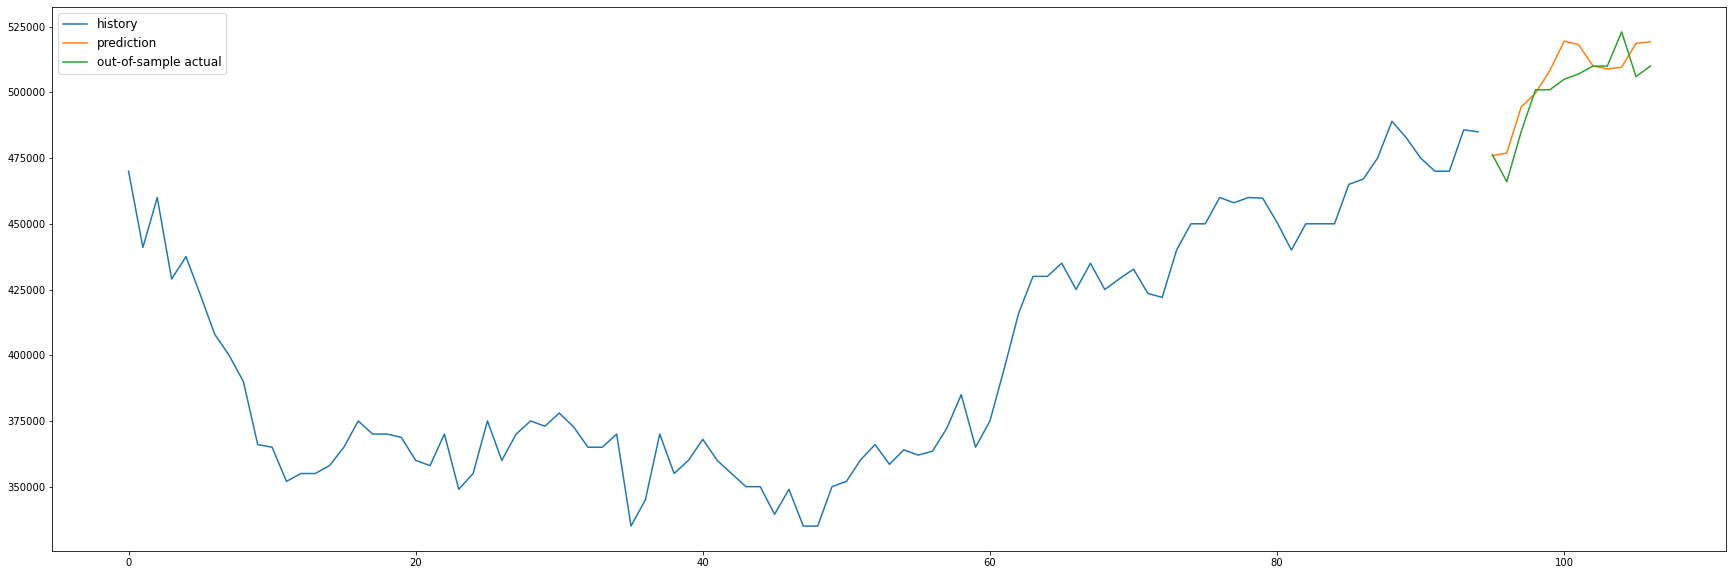

In [169]:
fig = plt.figure(figsize=(30, 10))
plt.plot(train_df, label='history')
plt.plot(y_pred_inv, label='prediction')
plt.plot(test['sold_price'], label='out-of-sample actual')
plt.legend(loc='upper left', fontsize=12)
plt.show()

In [156]:
y_pred_inv

array([475883.79209836, 476939.00344316, 494370.94985778, 499703.62137872,
       508317.89634307, 519494.26890688, 518147.4916527 , 510080.72641086,
       508914.07175778, 509570.46150738, 518663.40413532, 519178.13765308])